In [2]:
'''
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
GitHub: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.regularizers import l1

In [39]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('accuracy', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 784) (10000, 784)


In [16]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape = (input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')
# Here y_train = x_train as we need to output with dimensionality reduction of input images.
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1372
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0979
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0923


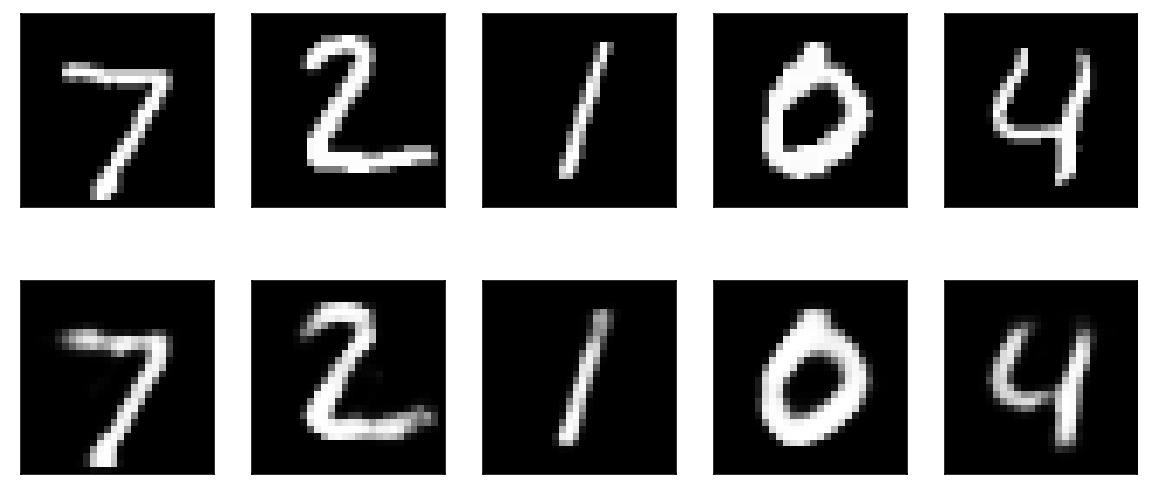

In [17]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

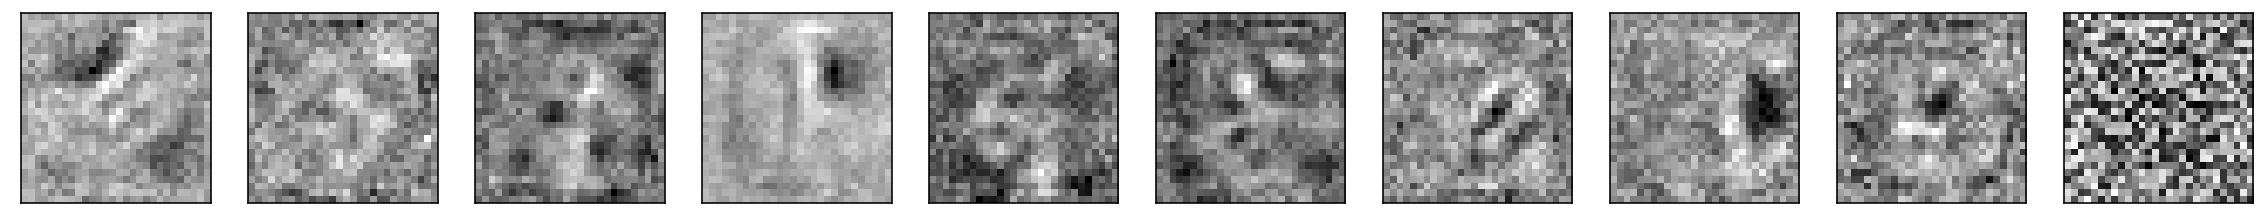

In [23]:
weights = autoencoder.get_weights()[0].T #Transpose

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [25]:
#Shallow Autoencoder
input_size = 784
code = 32
input_img = Input(shape = (input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='Adam', loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1617
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1043
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0964


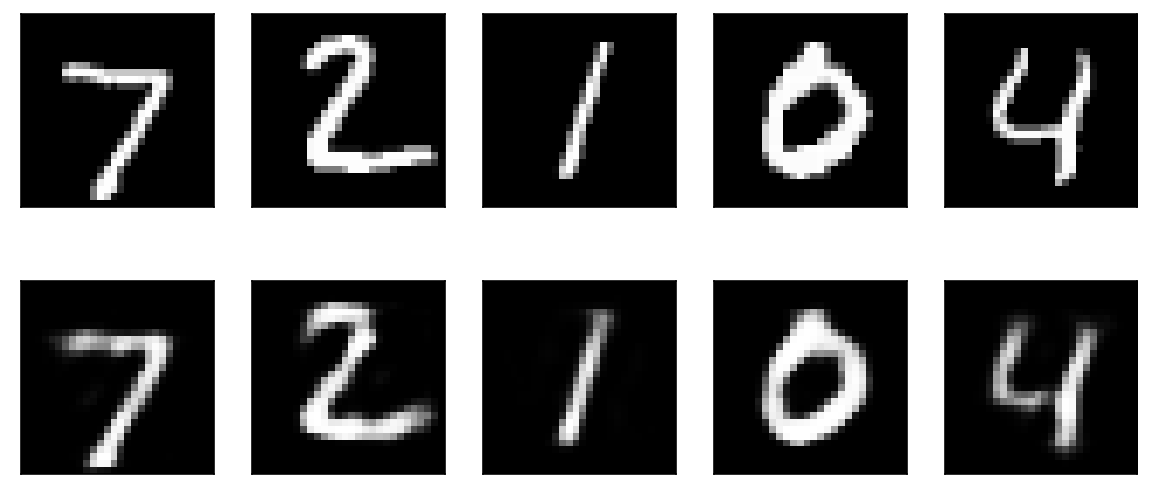

In [26]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

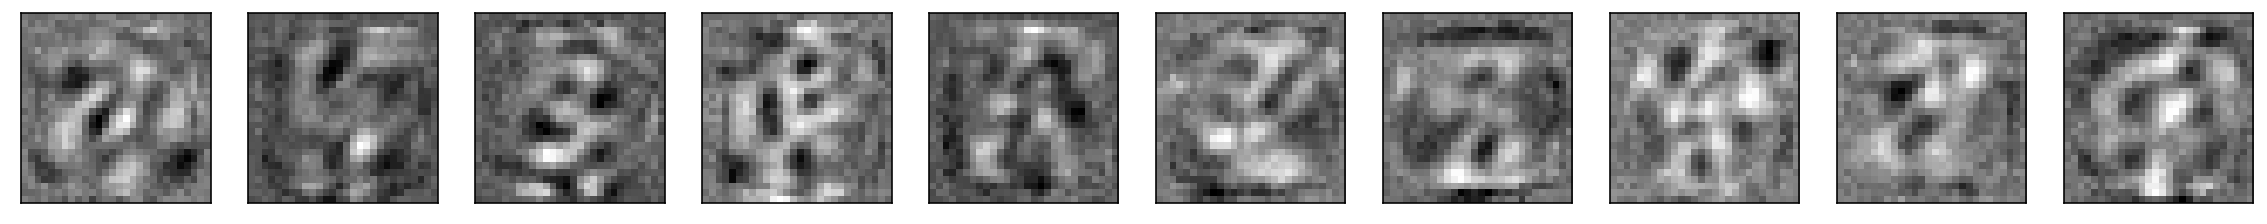

In [27]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

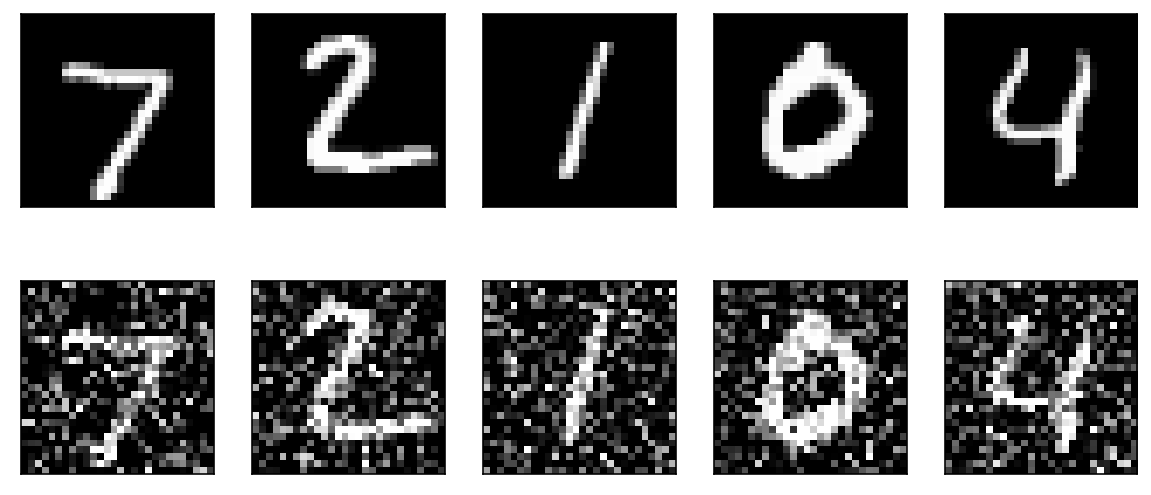

In [28]:
#Denoising autoencoders
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [30]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')
# Input = noisy input image and output = input image
autoencoder.fit(x_train_noisy, x_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1667
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1274
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1206
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1173
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1151
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1136
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1126
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1118
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1111
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1106
Epoch 11/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1101
Epoch 12/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1096
E

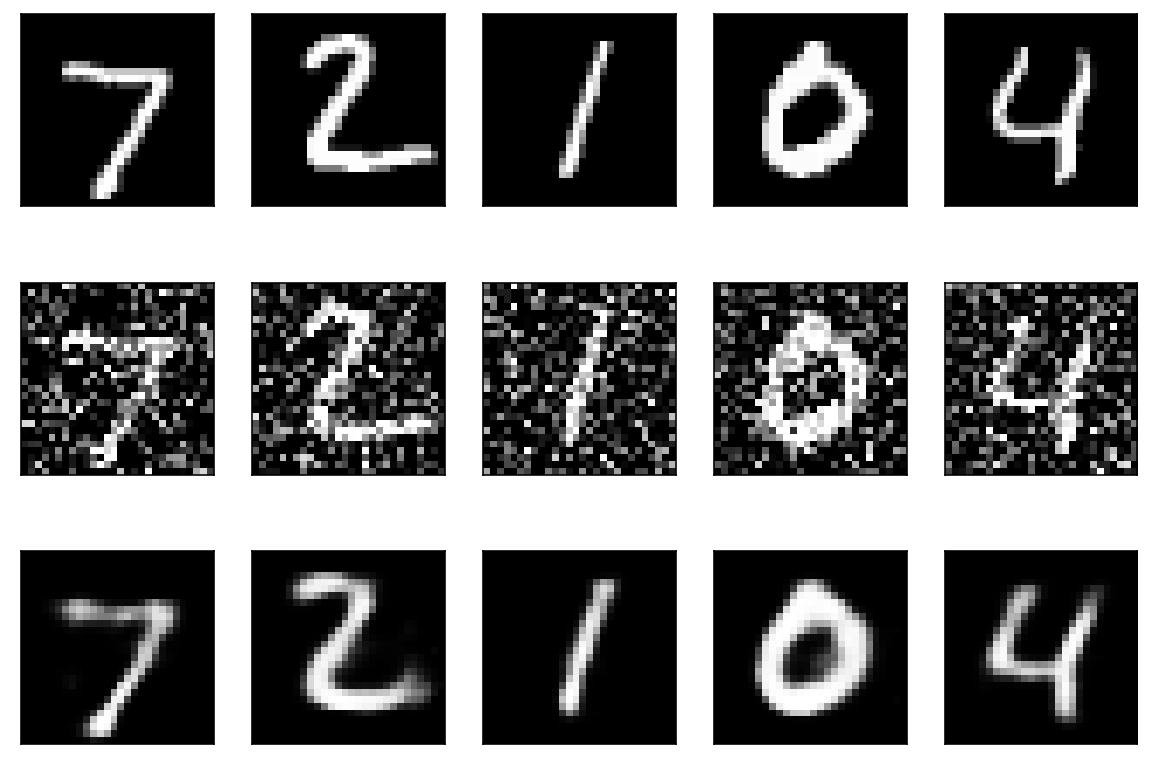

In [31]:
n = 5
plt.figure(figsize=(10, 7))

pred_images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(pred_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

In [46]:
# sparse encoders
# Without regularization
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1630A: 0s - loss:
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1050
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0967
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0951
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0945
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0942
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0940
Epoch 8/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0939A - 
Epoch 9/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0938A: 0s - loss: 0.09
Epoch 10/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0937
Epoch 11/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0936
Epoch 12/20
1875/1875 [===========================

In [47]:
# With regularization
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1617
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1056
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0984
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0971
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0966
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0963A: 0s - loss:
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0960
Epoch 8/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0959
Epoch 9/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0957
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955
Epoch 11/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954
Epoch 12/20
1875/1875 [==============================] - 3s 2ms/step - l

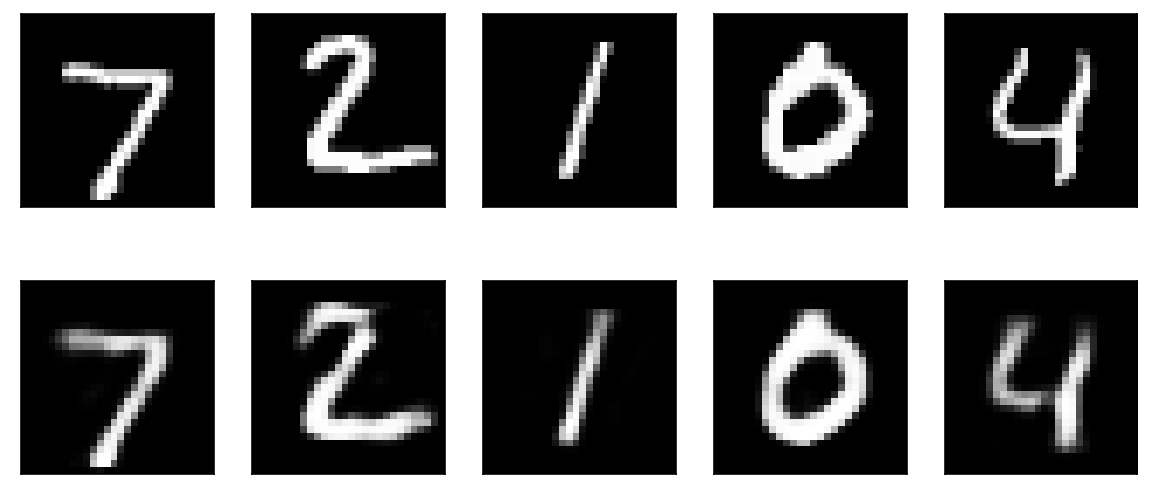

In [48]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

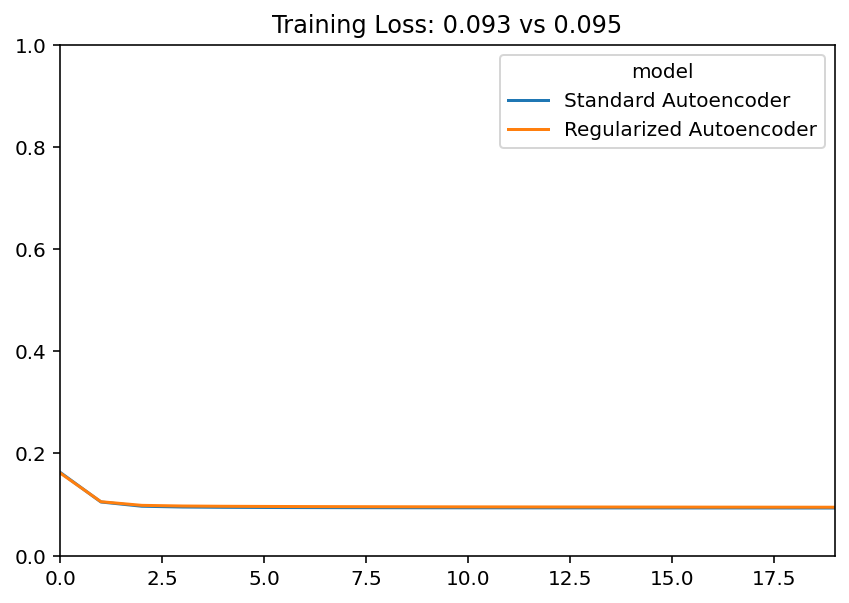

In [49]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [50]:
autoencoder_standard.evaluate(x_test, x_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0922


0.09215142577886581

In [51]:
autoencoder_regularized.evaluate(x_test, x_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0935


0.09346196055412292

In [52]:
encoded_standard.predict(x_test)

array([[ 3.1976812,  6.878339 ,  5.1695414, ...,  5.8804784,  7.965523 ,
         7.6999683],
       [ 8.042057 ,  5.600281 ,  7.792353 , ...,  7.598042 ,  7.325897 ,
         5.124447 ],
       [ 1.4433477,  2.184794 ,  4.361535 , ...,  0.9545046,  2.51237  ,
         4.359271 ],
       ...,
       [10.988959 ,  5.151202 ,  9.406276 , ...,  3.3374152,  7.893729 ,
        15.476684 ],
       [ 7.719904 ,  3.7722833,  0.       , ..., 10.078072 ,  6.558096 ,
         7.2829466],
       [14.010746 , 12.621656 ,  8.658232 , ..., 10.837722 , 11.63741  ,
         4.7201695]], dtype=float32)